<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-CV-NN/blob/main/SlowFast(2)%20add%20FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Read video

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

In [2]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Saving 1.mp4 to 1.mp4
1.mp4


In [3]:
# get video file informaiton
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
__width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
__height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('No. of frames = ', total_frames, ", w =", __width, ", h =", __height, ", fps=", fps)

No. of frames =  106 , w = 742 , h = 456 , fps= 10.0


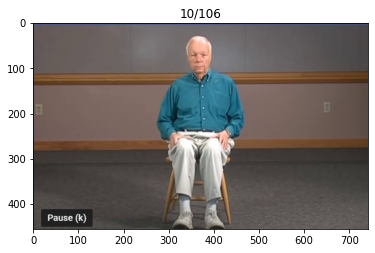

In [23]:
# take a look at the input video
MaxFrame = 10
frame_count = 1
try:
    while(frame_count <= MaxFrame):
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = vid.get_data(frame_count)  # Capture frame-by-frame
        frame_count += 1
        plt.imshow(frame)
        plt.pause(0.1)
except:
    print("Read video error!")

### Subject detection with FasterRCNN

In [24]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import pandas as pd
from scipy.optimize import linear_sum_assignment
import os

In [25]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  device=torch.device("cuda")
  print(torch.cuda.get_device_name(0))
else:
  device=torch.device("cpu")

Tesla K80


In [26]:
#Load Faster RCNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)

In [27]:
rect_th=3
text_th=3
text_size=2
class_index = 1 #people
score_threshold = 0.9  #threshold to recognize subject

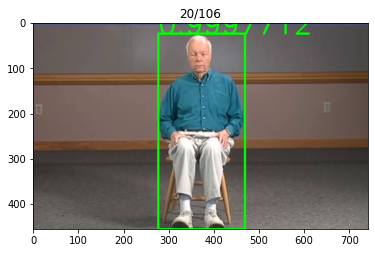

In [38]:
# collect bounding boxes of subjects for the first 20 frames
bboxLst =[]
frame_count = 1
while(frame_count <= 20):
  display.clear_output(wait=True)
  plt.title(str(frame_count)+'/'+str(total_frames))
  frame = vid.get_data(frame_count)  # Capture frame-by-frame
  transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(frame).to(device) # Apply the transform to the image
  pred = model([img])[0] # Pass the image to the model
  bboxLabels = list(pred['labels'].cpu().numpy())
  bboxScore = list(pred['scores'].cpu().detach().numpy())
  mask=[]
  for i in range(len(bboxLabels)): #find bbox with score > threshold
    if(bboxLabels[i]==class_index and bboxScore[i]>=score_threshold):
        mask.append(i)
  boxes = pred["boxes"][mask].data.cpu().numpy()
  bboxScore = list(pred['scores'][mask].cpu().detach().numpy())

  if(len(boxes) != 0):

    ### for this program, we only select the first bbox
    box0 = boxes[0]
    bboxScore0 = bboxScore[0]
    bboxLst.append(box0)
    x1,y1,x2,y2 = box0
    cv2.rectangle(frame,(x1,y1),(x2,y2),color=(0,255,0),thickness=rect_th) 
    cv2.putText(frame,str(bboxScore0),(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,text_size,(0,255,0),thickness=text_th) 
  frame_count += 1
  plt.imshow(frame)
  plt.pause(0.1)

In [39]:
print(len(bboxLst), bboxLst[0])

20 [276.06442   28.831076 469.31268  456.      ]


### Assume subject ID does not change, try to collect bbounding box frames

In [14]:
!pip install fvcore

     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 596 kB 9.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=46cd1ddfae4976f6a34fc7ffa6a8a7f587c25f4d6aa36b36752476304c611a3a
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
!pip install av

     |████████████████████████████████| 37.2 MB 137 kB/s 


In [19]:
from pytorchvideo.transforms.functional import (
    uniform_temporal_subsample,
    short_side_scale_with_boxes,
    clip_boxes_to_image,
)

In [45]:
print(len(bboxLst), bboxLst[0])

20 [276.06442   28.831076 469.31268  456.      ]


In [43]:
bboxArray = np.array(bboxLst)
print(bboxArray.shape, bboxArray[0])

(20, 4) [276.06442   28.831076 469.31268  456.      ]


In [44]:
boxes = clip_boxes_to_image(bboxArray, __height, __width)
print(boxes.shape, boxes[0])

(20, 4) [276.06442   28.831076 469.31268  455.      ]


In [ ]:
# take a look at the input video
MaxFrame = 10
frame_count = 1
try:
    while(frame_count <= MaxFrame):
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = vid.get_data(frame_count)  # Capture frame-by-frame
        frame_count += 1
        plt.imshow(frame)
        plt.pause(0.1)
except:
    print("Read video error!")

Slow fast is modified from PyTorch Hub https://pytorch.org/hub/

In [17]:
import torch
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth


  0%|          | 0.00/264M [00:00<?, ?B/s]

In [18]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


In [ ]:
model = model.eval()
model = model.to(device)

Download the id to label mapping for the Kinetics 400 dataset on which the torch hub models were trained. This will be used to get the category label names from the predicted class ids.

In [ ]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [ ]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [ ]:
#take a look at first 10 action labels
list(kinetics_id_to_classname.values())[:10] 

['sharpening knives',
 'eating ice cream',
 'cutting nails',
 'changing wheel',
 'bench pressing',
 'deadlifting',
 'eating carrots',
 'marching',
 'throwing discus',
 'playing flute']

#### Define input transform

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [ ]:
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(fname)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

#### Get Predictions

In [ ]:
# Pass the input clip through the model
preds = model(inputs)

In [ ]:
preds.shape

torch.Size([1, 400])

In [ ]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

In [ ]:
pred_classes

tensor([287,  91,  29, 132, 373], device='cuda:0')

In [ ]:
# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: setting table, dining, bookbinding, folding napkins, using computer


### Model Description
SlowFast model architectures are based on [1] with pretrained weights using the 8x8 setting
on the Kinetics dataset. 

| arch | depth | frame length x sample rate | top 1 | top 5 | Flops (G) | Params (M) |
| --------------- | ----------- | ----------- | ----------- | ----------- | ----------- |  ----------- | ----------- |
| SlowFast | R50   | 8x8                        | 76.94 | 92.69 | 65.71     | 34.57      |
| SlowFast | R101  | 8x8                        | 77.90 | 93.27 | 127.20    | 62.83      |


### References
[1] Christoph Feichtenhofer et al, "SlowFast Networks for Video Recognition"
https://arxiv.org/pdf/1812.03982.pdf